Using the ivar weighted data with the galaxy mask implemented in angle_calc_1730955668 (from 11/07/24) - checking cuts and generating mock timestream

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import pandas as pd
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1730955668/angle_calc_1730955668_spectra.npy',allow_pickle=True).item()

In [26]:
maps = np.array(list(spectra_dict.keys()))
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

264
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'meas_angle', 'meas_errbar', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut'])


In [4]:
for i in range(n_maps):
    if spectra_dict[maps[i]]['map_cut'] == 1:
        print(i)

43
44
45
229
230
240
241
242


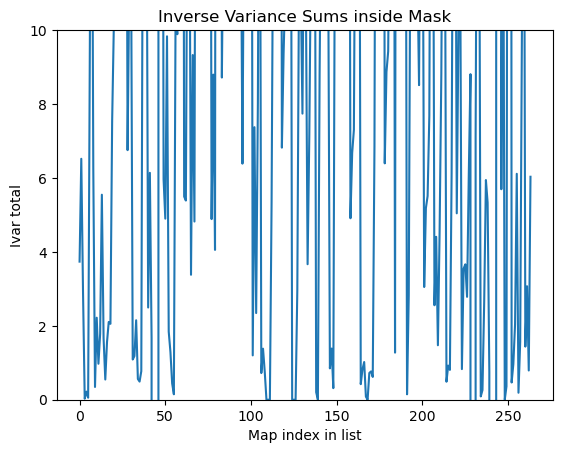

In [15]:
# Investigating trends in ivar_sum
ivar_sums = np.zeros(n_maps)
for i in range(n_maps):
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
plt.plot(ivar_sums)
plt.ylim(0,10)
plt.title("Inverse Variance Sums inside Mask")
plt.ylabel("Ivar total")
plt.xlabel("Map index in list")
plt.show()
plt.close()

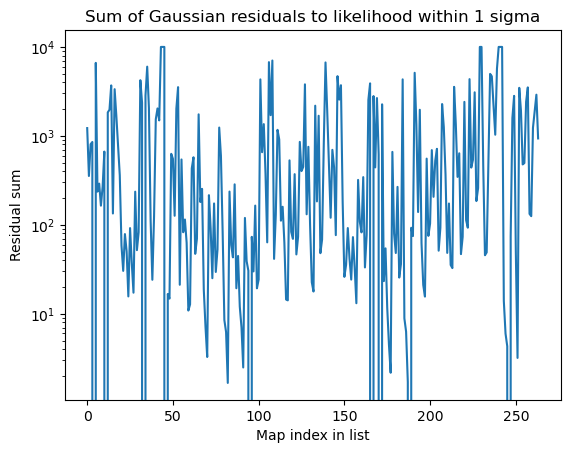

In [8]:
# Investigating trends in residual_sum
residual_sums = np.zeros(n_maps)
for i in range(n_maps):
    residual_sums[i] = np.abs(spectra_dict[maps[i]]['residual_sum'])
plt.semilogy(residual_sums)
plt.title("Sum of Gaussian residuals to likelihood within 1 sigma")
plt.ylabel("Residual sum")
plt.xlabel("Map index in list")
plt.show()
plt.close()

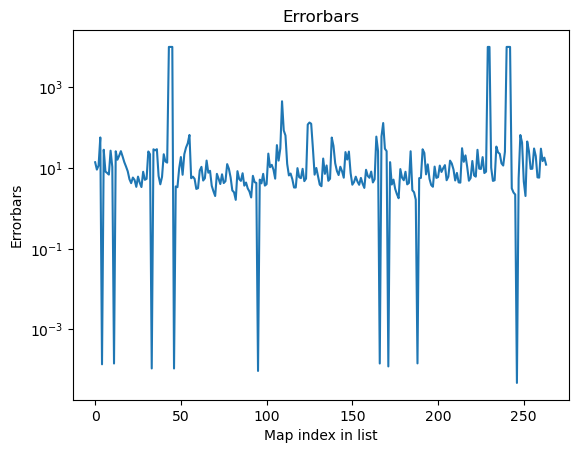

In [49]:
# Using the super small errorbars to identify the failed fits
all_errbars = np.zeros(n_maps)
for i in range(n_maps):
    all_errbars[i] = np.abs(spectra_dict[maps[i]]['meas_errbar'])
plt.semilogy(all_errbars)
plt.title("Errorbars")
plt.ylabel("Errorbars")
plt.xlabel("Map index in list")
plt.show()
plt.close()

In [53]:
errbar_good = np.where(all_errbars>0.1)[0]
print(errbar_good)

[  0   1   2   3   5   6   7   8   9  10  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37  38
  39  40  41  42  43  44  45  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 167
 168 169 170 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 247 248 249 250 251 252 253 254 25

In [38]:
ivar_good = np.where(ivar_sums>3.5)[0]
residual_good = np.where(residual_sums<800)[0]
print(ivar_good)
print(residual_good)
print(np.where(residual_sums==9999)[0])

[  0   1   6   7   8  13  19  20  21  22  23  24  25  26  27  28  29  30
  37  38  39  41  46  47  48  49  50  51  56  57  58  59  60  61  62  63
  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 102 104 105 112 113 114 115 116 117 118 119 120 121 122 123 128 129 130
 131 132 133 134 135 136 137 140 141 142 143 144 145 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 172 173 174 175 176 177 178 179
 180 181 182 183 185 186 187 188 189 190 193 194 195 196 197 198 199 200
 202 203 204 205 206 208 210 211 212 213 217 218 219 220 221 222 224 225
 227 228 231 232 233 237 238 243 244 245 246 247 250 251 255 258 259 263]
[  1   4   6   7   8   9  10  11  15  18  19  20  21  22  23  24  25  26
  27  28  29  30  33  37  38  39  46  47  48  49  50  51  54  55  56  57
  58  59  60  61  62  63  64  66  67  68  69  70  71  72  73  74  75  76
  78  79  80  81  82  83  84  85  86  87  88  89  

In [55]:
all_good = np.intersect1d(np.intersect1d(ivar_good,residual_good),errbar_good)
print(len(all_good))
print(all_good)

161
[  1   6   7   8  19  20  21  22  23  24  25  26  27  28  29  30  37  38
  39  47  48  49  50  51  56  57  58  59  60  61  62  63  64  66  67  68
  69  70  71  72  73  74  75  76  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  96  97  98  99 100 102 104 105 113 114 115
 116 117 118 119 120 121 122 123 128 129 130 131 132 134 136 137 141 142
 143 144 145 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 173 174 175 176 177 178 179 180 181 182 183 185 186 187 189 190 193 195
 196 197 198 199 200 202 203 204 205 206 210 211 212 213 217 218 219 221
 222 224 225 227 228 231 232 233 243 244 245 247 250 251 255 258 259]


In [71]:
timestamps = np.array([int(maps[i].split('_')[1]) for i in all_good])
arrays = np.array([maps[i].split('_')[2] for i in all_good])
angles = np.array([spectra_dict[maps[i]]['meas_angle'] for i in all_good])
errbars = np.array([spectra_dict[maps[i]]['meas_errbar'] for i in all_good])
print(timestamps[13:-9])

[1513422389 1513422389 1513422389 1513445778 1513445778 1513445778
 1513481732 1513481732 1513508790 1513515669 1513515669 1513948346
 1513948346 1513997690 1513997690 1513997690 1514027190 1514032657
 1514032657 1514032657 1514085395 1514085395 1514095540 1514095540
 1514095540 1514113590 1514113590 1514113590 1514120675 1514120675
 1514120675 1514157149 1514157149 1514164714 1514164714 1514164714
 1514192734 1514192734 1514192734 1514204984 1514204984 1514204984
 1514243670 1514243670 1514243670 1514277406 1514277406 1514277406
 1514286389 1514286389 1514293005 1514293005 1514293005 1514329590
 1514339718 1514339718 1514426261 1514426261 1514439491 1514439491
 1514439491 1514459190 1514459190 1514459190 1514465335 1514465335
 1514465335 1514549638 1514549638 1514604851 1514604851 1514604851
 1514631990 1514638410 1514638410 1514675189 1514675189 1514686641
 1514686641 1514686641 1514721969 1514721969 1514721969 1514761590
 1514761590 1514761590 1514789181 1514789181 1514789181 151480

Text(0.5, 1.0, 'Sample Timestream')

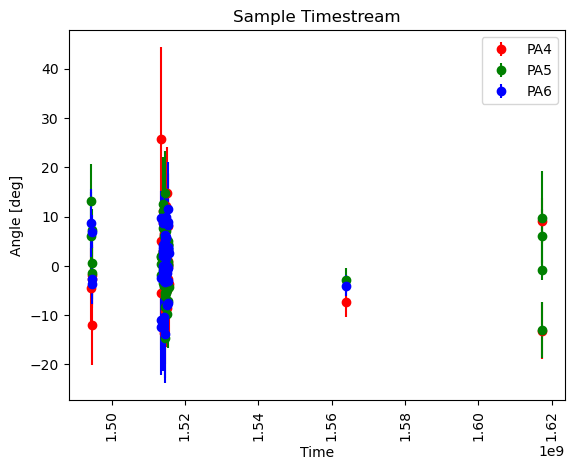

In [63]:
plt.xticks(rotation=90)
plt.errorbar(timestamps[arrays=='pa4'],angles[arrays=='pa4'],yerr=errbars[arrays=='pa4'],fmt='ro',label="PA4")
plt.errorbar(timestamps[arrays=='pa5'],angles[arrays=='pa5'],yerr=errbars[arrays=='pa5'],fmt='go',label="PA5")
plt.errorbar(timestamps[arrays=='pa6'],angles[arrays=='pa6'],yerr=errbars[arrays=='pa6'],fmt='bo',label="PA6")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Angle [deg]')
plt.title('Sample Timestream')
#plt.tight_layout()

Text(0.5, 1.0, 'Angles from Three Weeks of Depth-1 Maps')

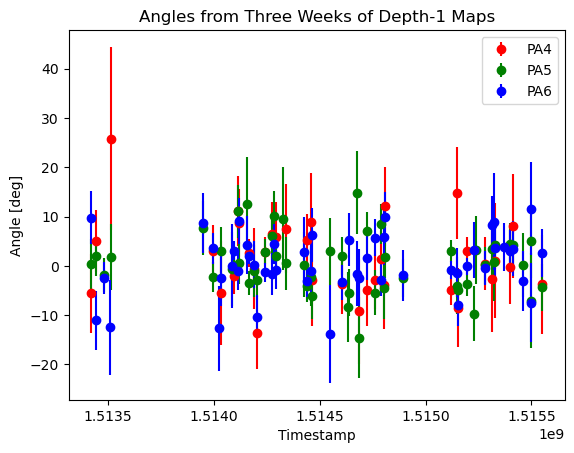

In [76]:
# Plotting only the second bank
plt.xticks(rotation=0)
plt.errorbar(timestamps[13:-9][arrays[13:-9]=='pa4'],angles[13:-9][arrays[13:-9]=='pa4'],yerr=errbars[13:-9][arrays[13:-9]=='pa4'],fmt='ro',label="PA4")
plt.errorbar(timestamps[13:-9][arrays[13:-9]=='pa5'],angles[13:-9][arrays[13:-9]=='pa5'],yerr=errbars[13:-9][arrays[13:-9]=='pa5'],fmt='go',label="PA5")
plt.errorbar(timestamps[13:-9][arrays[13:-9]=='pa6'],angles[13:-9][arrays[13:-9]=='pa6'],yerr=errbars[13:-9][arrays[13:-9]=='pa6'],fmt='bo',label="PA6")
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Angle [deg]')
plt.title('Angles from Three Weeks of Depth-1 Maps')
#plt.tight_layout()